In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2xy(df, feat_col=None, target_col=None, data_cols=None, to3d=True, splits=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    target_col: indicates the column/s where the target is.
    data_col: indicates where the data is located. If None, it means all columns (excpet the target)
    """
    no_data_cols = []
    if feat_col is not None: no_data_cols.append(feat_col[0] if is_listy(feat_col) else feat_col)
    if target_col is not None: no_data_cols.append(target_col[0] if is_listy(target_col) else target_col)
    if data_cols is None: data_cols = [col for col in df.columns if col not in no_data_cols]
    n_feats = len(df[feat_col].unique()) if feat_col is not None else 1
    data = df.loc[:, data_cols].values
    _, seq_len = data.shape
    if to3d: X = data.reshape(n_feats, -1, seq_len).transpose(1, 0, 2)
    else: 
        assert feat_col is None, 'When feat_col is not None you must set to3d=True'
        X = data
    if X.dtype == 'O': X = X.astype(np.float32)
    if target_col is not None: y = np.split(df[target_col].values, n_feats)[0]
    else: y = None
    if splits is None: return X, y
    else: return split_xy(X, y, splits)


def split_xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]

In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


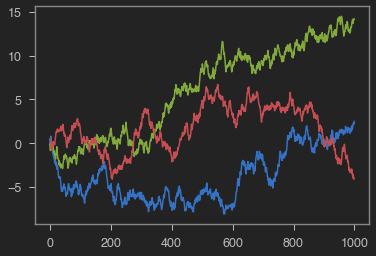

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,0.015784,-0.193637,-0.492012
1,-0.186398,-0.490267,-0.689044
2,-0.504185,-0.326022,-1.073668
3,-0.875581,-0.747291,-0.776752
4,-0.768930,-0.700539,-0.594630
...,...,...,...
95,-0.884496,3.220149,-4.114778
96,-0.783482,3.101014,-4.095734
97,-0.646633,3.496706,-3.805410
98,-0.418485,3.760338,-3.515848


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.034987,0.265419,0.388978,-0.477597,0.216639
1,0.306621,0.175194,0.007749,-0.596367,0.518810
2,-0.041105,0.172147,0.351845,-0.651376,0.886343
3,-0.475638,-0.122580,0.597261,-0.249355,1.116616
4,-0.504546,-0.271079,0.859025,-0.030649,1.070399
...,...,...,...,...,...
95,1.521595,-0.764979,0.667607,-2.825076,0.091575
96,1.353080,-0.473150,1.140333,-2.739102,0.284244
97,1.084501,-0.331407,1.405139,-2.956928,-0.031723
98,1.531432,-0.603270,1.208083,-3.379310,0.201203


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.015260,-0.295256,-0.371846,-0.058090,0.287743,0.600190,0.729011,1.128158,1.469513,1.834227,...,0.760561,0.404793,0.211156,0.346334,-0.052847,0.163347,0.176660,0.320087,0.107224,0.535160
var_1,0.298901,-0.083420,-0.133201,-0.297466,-0.623616,-0.585432,-0.300040,-0.673546,-0.991523,-0.671022,...,0.441698,0.800108,1.071239,0.879326,1.031965,0.962477,0.904705,1.055780,1.284574,0.809006
var_2,-0.290568,-0.746929,-1.212068,-1.412135,-1.712125,-1.477495,-1.625440,-1.128844,-0.849584,-0.466964,...,-2.342662,-2.751593,-2.605057,-3.016861,-2.565442,-2.357582,-2.041641,-1.802940,-2.125555,-1.988647
var_3,0.125964,-0.123366,0.365990,0.741162,0.974703,0.961637,0.895115,0.637948,1.000763,1.494473,...,0.056814,-0.274021,-0.329318,-0.342510,-0.769576,-0.650752,-0.247958,-0.713542,-0.866039,-0.424461
target,0.417843,-0.062142,-0.538591,-0.716490,-0.856111,-1.321726,-1.028673,-1.170480,-1.167540,-0.873429,...,-2.423965,-2.632745,-2.583390,-2.942321,-2.662171,-2.374877,-1.884027,-2.362254,-2.223728,-1.809517


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.235221,-0.584309,-0.649584,-1.064853,-1.375698,-1.280497,-1.538258,-1.488249,-1.139341,-1.249206,...,0.312832,0.245245,-0.042700,-0.278418,-0.675769,-0.951848,-0.588645,-0.372795,0.084416,-0.189254
var_1,0.484481,0.169799,0.577876,0.118410,-0.250787,-0.630433,-0.956636,-1.357982,-1.492803,-1.309581,...,1.480351,1.849079,1.529784,1.234918,1.509814,1.166909,1.584217,1.928563,1.924577,1.940974
var_2,-0.164402,-0.663064,-0.579642,-0.390447,-0.874379,-1.054921,-0.830563,-1.151699,-1.215978,-1.684522,...,-2.066668,-2.153500,-1.939983,-2.121127,-1.905424,-1.605140,-1.763160,-2.256251,-2.040541,-2.274361
var_3,-0.466548,-0.749546,-1.060546,-0.583555,-0.803596,-0.739522,-1.017982,-0.631410,-0.973913,-0.921208,...,2.914970,2.638937,3.032135,2.680589,2.188857,1.915098,2.238422,2.159059,2.084585,2.273964
target,0.169461,0.309297,0.773271,0.909726,0.490006,0.398375,0.118626,0.464111,0.356092,0.312113,...,1.589101,1.149127,1.336705,1.112568,0.844260,0.799816,0.647883,0.945521,0.539120,0.939570


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.277859,-0.075348,0.189742,0.276420,-0.328928
1,-0.058482,0.207139,0.002412,0.432864,-0.196618
2,-0.435408,0.043785,0.495162,0.602221,-0.162279
3,-0.563453,-0.229668,0.897139,0.554593,-0.645325
4,-0.676686,0.159040,1.010887,0.435085,-0.742859
...,...,...,...,...,...
95,0.866528,-2.796599,-2.556825,-0.810228,1.599277
96,0.498209,-2.658270,-2.110805,-0.862007,2.027504
97,0.869788,-2.692093,-2.456531,-1.056318,1.767055
98,1.199173,-3.035825,-2.799082,-0.772680,1.789441


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,16799,167990,1679900,16799000,167990000,1679900000,16799000000,167990000000,1679900000000,16799000000000,16799,0,1,A,16799
1,25794,257922,2579202,25792000,257920000,2579200000,25792000000,257920000000,2579200000000,25792000000000,25792,2,3,B,125796
2,80130,801300,8013000,80130000,801300000,8013000000,80130000000,801300000000,8013000000000,80130000000000,80130,0,1,A,80130
3,18302,183020,1830200,18302000,183020000,1830200000,18302000000,183020000000,1830200000000,18302000000000,18302,0,0,A,18302
4,30692,306902,3069002,30690000,306900000,3069000000,30690000000,306900000000,3069000000000,30690000000000,30690,2,2,B,130694


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 10, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 007_metrics.ipynb.
Converted 008_learner.ipynb.
Converted 009_optimizer.ipynb.
Converted 010_callback.core.ipynb.
Converted 011_callback.noisy_student.ipynb.
Converted 012_callback.gblend.ipynb.
Converted 013_callback.TSBERT.ipynb.
Converted 014_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.ResNetPlus.ipynb.
Converted 102_models.InceptionTime.ipynb.
Converted 102b_models.InceptionTimePlus.ipynb.
Co